## Домашнее задание 1. Обучение LeNet

На прошлой лабораторной мы рассмотрели пример обучения небольшой нейронной сети для классификации датасета CIFAR-10. В качестве домашнего задания вам предлагается классификация предметов одежды из датасета [**Fashion MNIST**](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST). Вы можете начать с имплементации классической сверточной сети [LeNet](https://en.wikipedia.org/wiki/LeNet) и улучшить ее методами, которые мы обсудили на лекции (dropout, batchnorm, etc).

## Импорт модулей

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim import Adam, lr_scheduler

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

c:\Users\ivana\MLInnopolis\.mlinnopolis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Константы

In [2]:
RANDOM_SEED = 15
TEST_SIZE = 0.2
BATCH_SIZE = 2048
EPOCHS = 100

## Загрузка датасета

In [3]:
class FashionMnistDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
# Разделение датасета
fashion_mnist_dataset = torchvision.datasets.FashionMNIST(
    root="fashion", download=True, transform=None
)

test_size = int(len(fashion_mnist_dataset) * TEST_SIZE)
val_size = test_size
train_size = len(fashion_mnist_dataset) - val_size - test_size

train_data, val_data, test_data = random_split(
    fashion_mnist_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(RANDOM_SEED),
)

train_dataset = FashionMnistDataset(train_data, transform=T.ToTensor())
val_dataset = FashionMnistDataset(val_data, transform=T.ToTensor())
test_dataset = FashionMnistDataset(test_data, transform=T.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(val_loader.dataset)}")
print(f"Number of test samples: {len(test_loader.dataset)}")

Number of training samples: 36000
Number of validation samples: 12000
Number of test samples: 12000


## Архитектура LeNet

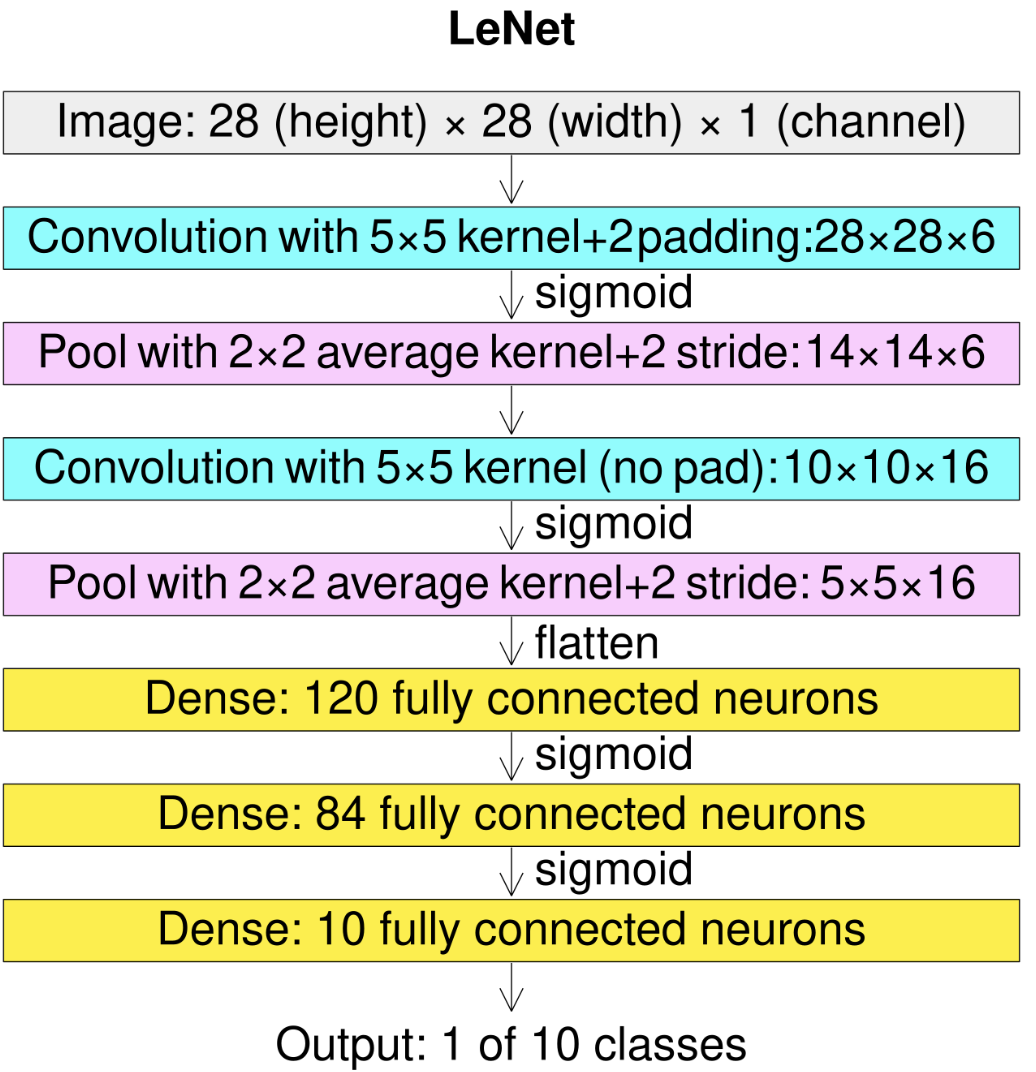



### **Задание 1**: закончите имплементацию LeNet согласно диаграме сверху

In [5]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, padding=0),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        self.flatten = nn.Flatten()
        self.dense_block = nn.Sequential(
            nn.Linear(5 * 5 * 16, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10),
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.flatten(x)
        x = self.dense_block(x)

        return F.log_softmax(x, dim=1)

### **Задание 2**: Напишите функцию обучения

Вы можете воспользоваться кодом из прошлой лабораторной работы

Посчитайте точность на валидационном сете.

In [6]:
# Функции для обучения и валидации
def train_one_epoch(model, loader, criterion, optimizer, device=torch.device("cuda")):
    model.train()
    epoch_loss = 0
    correct = 0
    iteration = 0

    for data, target in loader:
        data, target = data.to(device), target.to(device)

        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)

        correct += pred.eq(target.view_as(pred)).sum().item()
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        iteration += 1

    epoch_loss = epoch_loss / len(loader)
    accuracy = correct / len(loader.dataset)

    return epoch_loss, accuracy


def validate(model, loader, criterion=None, device=torch.device("cuda")):
    model.eval()
    if criterion:
        val_loss = 0
    else:
        val_loss = None
    correct = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)

            if criterion:
                val_loss += criterion(output, target).item()
            correct += pred.eq(target.view_as(pred)).sum().item()

    if criterion:
        val_loss = val_loss / len(loader)
    accuracy = correct / len(loader.dataset)

    return val_loss, accuracy


def train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler=None,
    epochs=10,
    device=torch.device("cuda"),
):
    train_losses = []
    train_metrics = []

    val_losses = []
    val_metrics = []

    best_metric = 0
    best_model = None

    progress_bar = tqdm(range(1, epochs + 1), desc="Training", leave=True, total=epochs)

    for epoch in progress_bar:
        train_loss, train_metric = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )
        train_losses.append(train_loss)
        train_metrics.append(train_metric)

        val_loss, val_metric = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)

        if val_metric > best_metric:
            best_metric = val_metric
            best_model = model

        if scheduler:
            if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        progress_bar.set_postfix(
            {
                "Epoch": epoch,
                "Val Loss": f"{val_loss:.4f}",
                "Val Accuracy": f"{val_metric:.4f}",
            }
        )

    result = {
        "best_model": best_model,
        "last_model": model,
        "train_losses": train_losses,
        "train_metrics": train_metrics,
        "val_losses": val_losses,
        "val_metrics": val_metrics,
    }
    print("Done!")

    return result

In [7]:
# Функция для визуализации результатов
def show_results(results, title=""):
    _, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].plot(results["train_losses"], label="Train Loss")
    ax[0].plot(results["val_losses"], label="Validation Loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].grid(True)
    ax[0].legend()

    ax[1].plot(results["train_metrics"], label="Train Accuracy")
    ax[1].plot(results["val_metrics"], label="Validation Accuracy")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].grid(True)
    ax[1].legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

results_lenet = train(
    model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS, device=device
)

Training: 100%|██████████| 100/100 [10:55<00:00,  6.56s/it, Epoch=100, Val Loss=0.4243, Val Accuracy=0.8461]

Done!


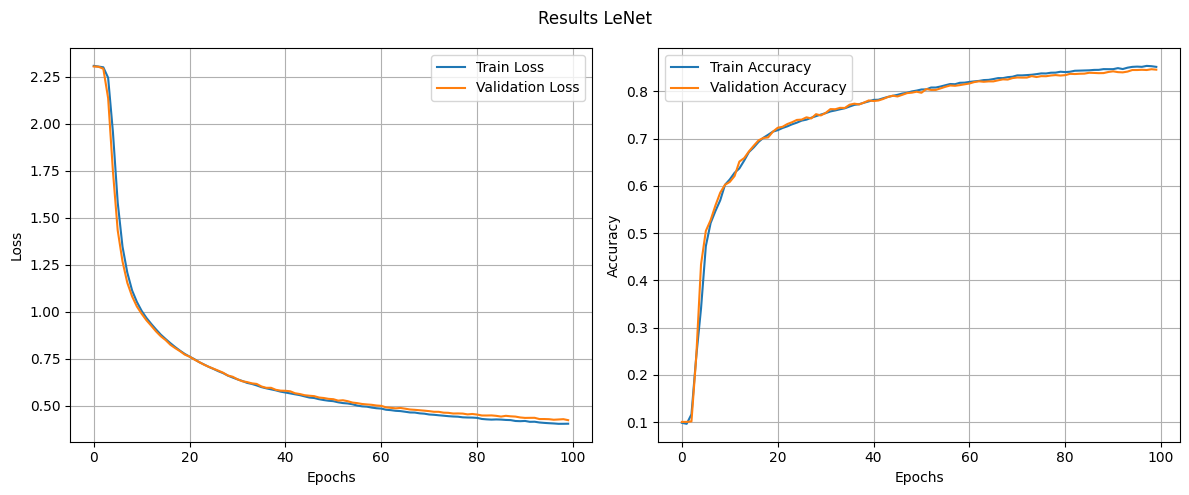

LeNet Test Accuracy: 0.8466


In [9]:
show_results(
    results_lenet,
    title="Results LeNet",
)

print(
    f"LeNet Test Accuracy: {validate(results_lenet["best_model"], test_loader, device=device)[1]:.4f}"
)

На тестовой выборке достигнута метрика Accuracy в 84.6%.

### **Задание 3**: Улучшите обучение продвинутыми методами

Вы можете добавить
- Dropout;
- BatchNorm;
- Data augmentation;
- Больше сверток к сети;
- Функции активации (ReLU, tahn, etc);
- Adam optimizer вместе с LR scheduler

In [10]:
class FashionLeNet(nn.Module):
    def __init__(self):
        super(FashionLeNet, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.dense_block = nn.Sequential(
            nn.Linear(128 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flatten(x)
        x = self.dense_block(x)

        return F.log_softmax(x, dim=1)

In [11]:
# Добавление аугментации
train_transform = T.Compose(
    [
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomRotation(10),
        T.ToTensor(),
        T.Normalize((0.5,), (0.5,)),
    ]
)
val_transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize((0.5,), (0.5,)),
    ]
)

train_dataset = FashionMnistDataset(train_data, transform=train_transform)
val_dataset = FashionMnistDataset(val_data, transform=val_transform)
test_dataset = FashionMnistDataset(test_data, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FashionLeNet().to(device)

criterion = nn.NLLLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", factor=0.9, patience=3, min_lr=0.0001
)

results_fashion_lenet = train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    device=device,
)

Training: 100%|██████████| 100/100 [27:04<00:00, 16.25s/it, Epoch=100, Val Loss=0.2248, Val Accuracy=0.9274]

Done!


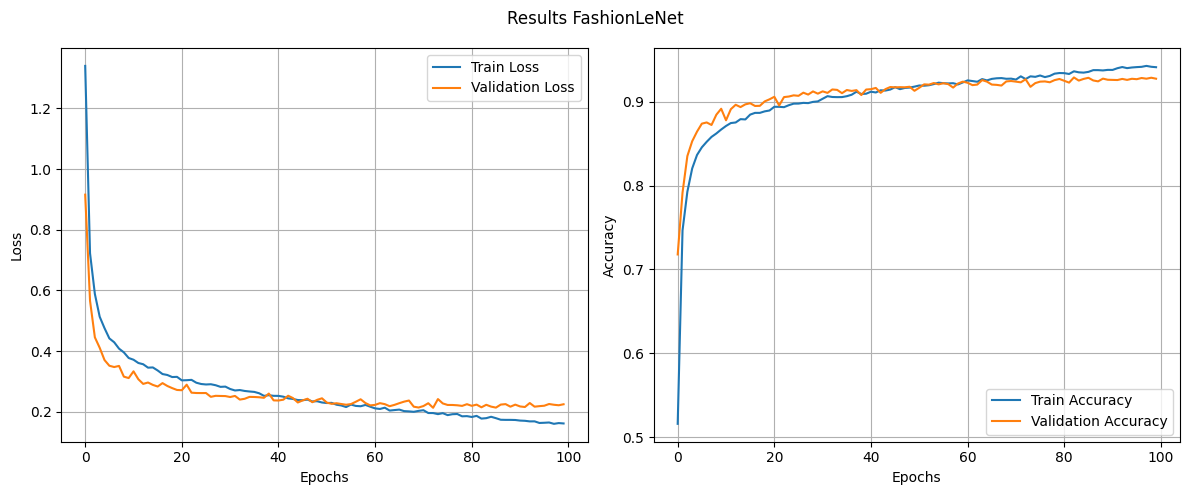

FashionLeNet Test Accuracy: 0.9256


In [13]:
show_results(
    results_fashion_lenet,
    title="Results FashionLeNet",
)

print(
    f"FashionLeNet Test Accuracy: {validate(results_fashion_lenet["best_model"], test_loader, device=device)[1]:.4f}"
)

После улучшения модели удалось увеличить метрику Accuracy на тестовом наборе до 92,5%.